In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-46/data.npy")
gen_data=np.load("../data/generated_data/data.npy")

In [3]:
mu_data.shape

(10000, 3, 101)

In [4]:
gen_data.shape

(1000, 3, 101)

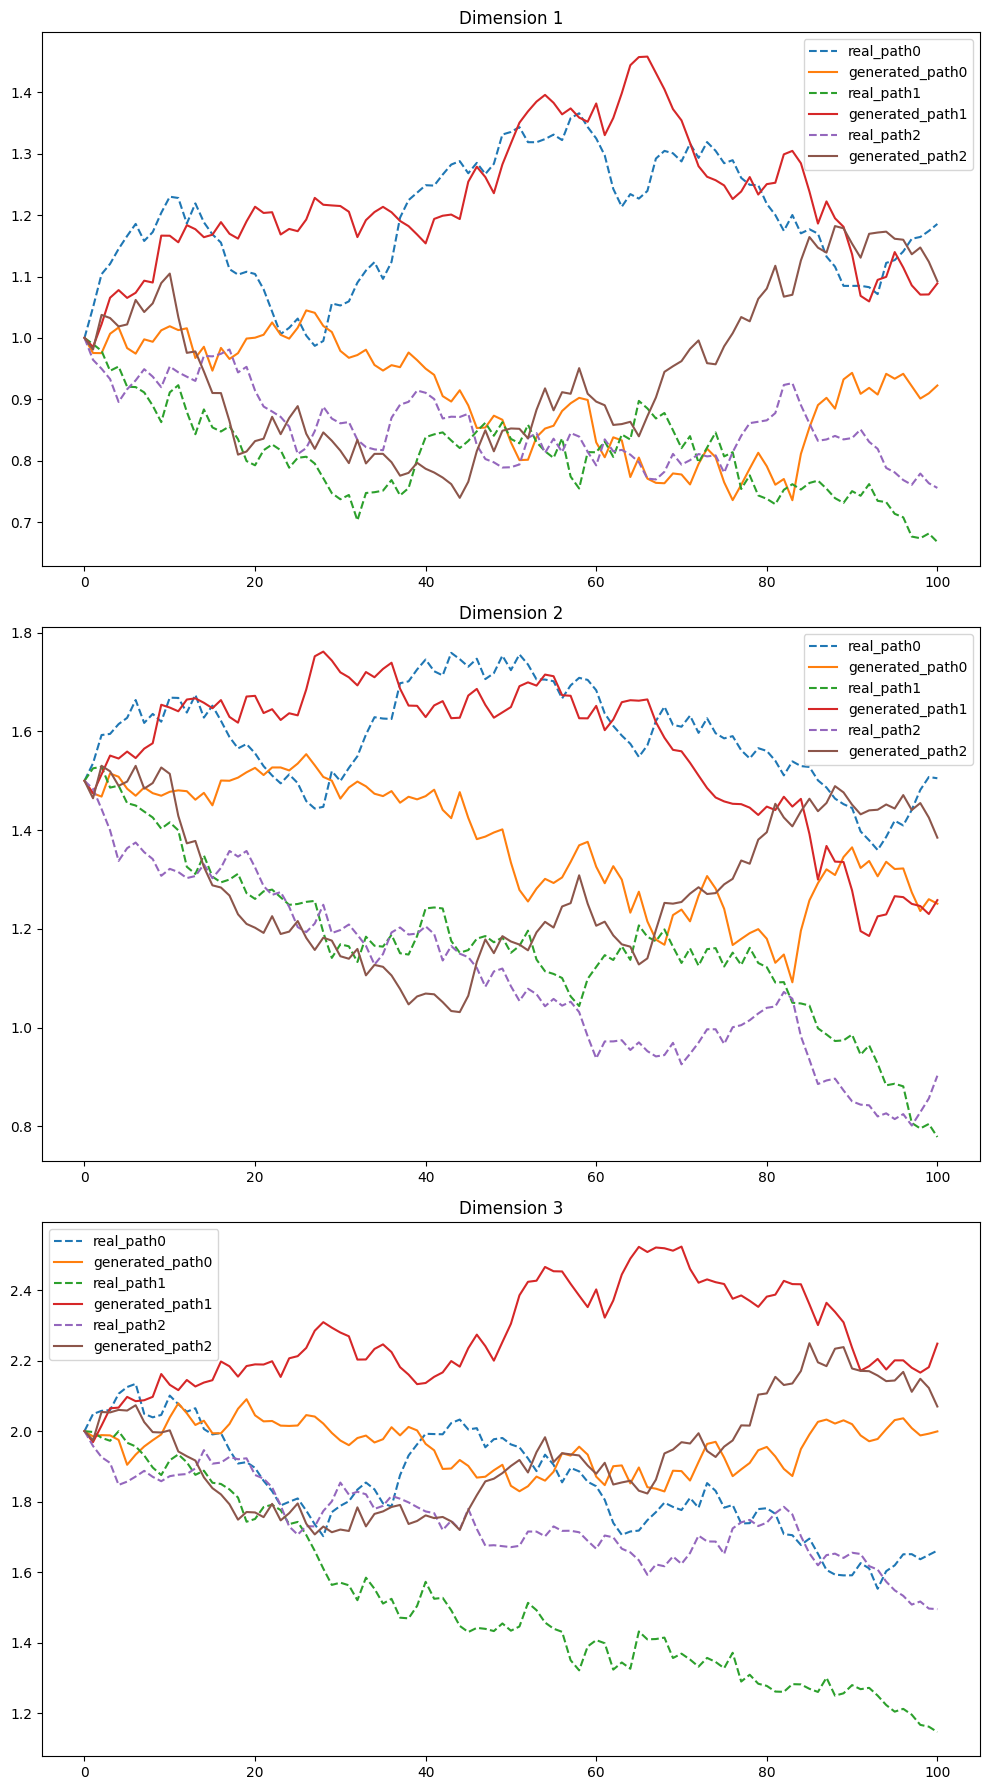

In [133]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = gen_data[:,i, :].T

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")
        axs[i].plot(generated_path[:,j], label=f'generated_path{j}')
    #axs[i].plot(generated_path.detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

In [134]:
real_data = torch.tensor(mu_data[:1000, 0, :])
fake_data = torch.tensor(gen_data[:1000, 0, :]) 

In [135]:
def compare_path(x_real, x_fake, titles=None, file_path=None, return_figax=False, plot_size=1000):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
    ax[0].plot(
        x_real[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    ax[1].plot(
        x_fake[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    if titles:
        ax[0].set_title(titles[0])
        ax[1].set_title(titles[1])

    for i in range(2):
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Prices")
    if return_figax:
        return fig, ax
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
    plt.close()

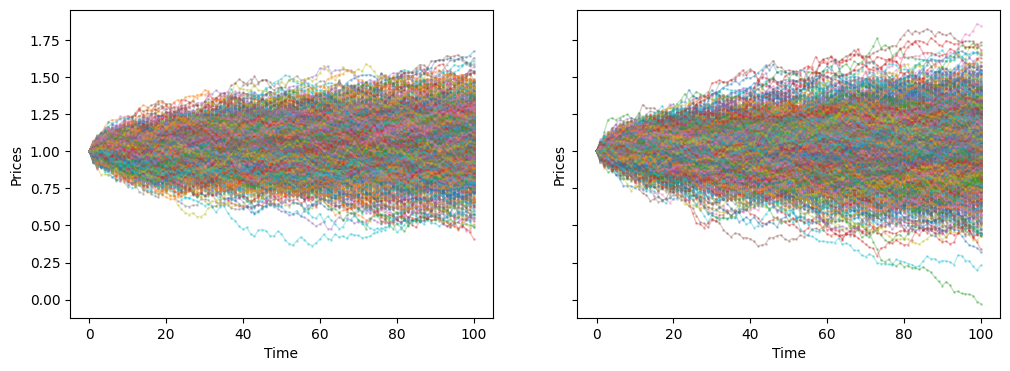

In [136]:
compare_path(real_data,fake_data)

In [1]:
# Compare Drift and Volatility
def prices2returns(prices):
    returns = prices[:, 1:] / prices[:, :-1] - 1
    return returns


def compute_volatility(price_path, T):
    return_path = prices2returns(price_path)
    vol2 = torch.sum(return_path**2,dim=1) / T
    vol = torch.sqrt(vol2)
    return vol


def compute_drift(price_path, T):
    return_path = prices2returns(price_path)
    drift = torch.sum(return_path,dim=1) / T
    return drift


def plot_mean_log_prices(data, data_name, axi):
    data = torch.log(data)
    data_mean = torch.mean(data,dim=0)
    data_std = torch.std(data,dim=0)
    axi.plot(data_mean, marker="o", linewidth=1, markersize=1, label=data_name)
    axi.fill_between(
        torch.arange(len(data_mean)),
        data_mean - data_std,
        data_mean + data_std,
        alpha=0.2,
    )


def compare_drift_volatility(real_data, fake_data, T=1, file_path=None):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4])

    plot_mean_log_prices(real_data, "real", ax[0])
    plot_mean_log_prices(fake_data, "fake", ax[0])
    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_title("Log-prices")

    vol = compute_volatility(real_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="real", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    vol = compute_volatility(fake_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="fake", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    ax[1].legend()
    ax[1].set_title("Volatility")
    ax[1].set_xlabel("Volatility")

    if file_path is not None:
        plt.savefig(file_path, bbox_inches="tight")
    plt.show()

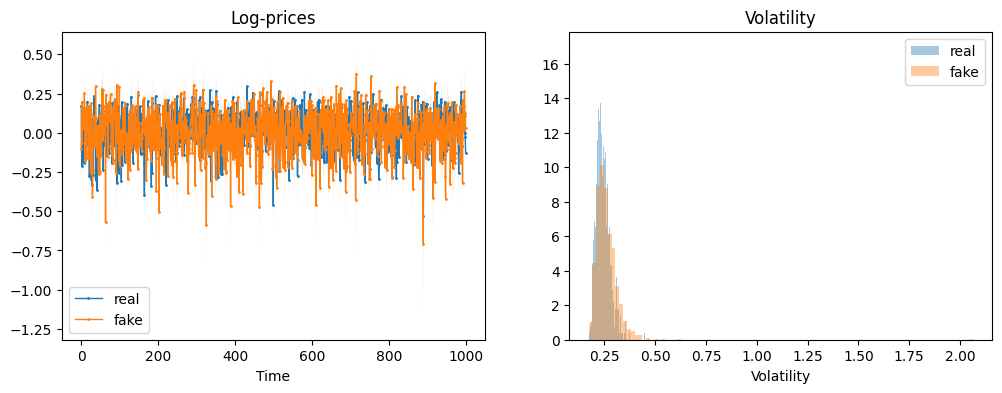

In [138]:
compare_drift_volatility(real_data,fake_data)

In [139]:
from scipy.linalg import logm
def estimate_ou_params(paths: np.ndarray, dt: float = 0.01):
    """
    ----------
    paths : ndarray, shape (n_paths, d, n_steps + 1)
        Simulated OU trajectories.
    dt    : float
        Sampling interval of the data.

    Returns
    -------
    k : (d, d) ndarray  
    mu    : (d,)  ndarray   
    Q     : (d, d) ndarray  
    """
    n_paths, d, n_steps_plus1 = paths.shape
    n_steps = n_steps_plus1 - 1

    X0 = paths[:, :, :-1].transpose(0, 2, 1)          
    X1 = paths[:, :,  1:].transpose(0, 2, 1)

    X0 = X0.reshape(-1, d)
    X1 = X1.reshape(-1, d)
    Z    = np.hstack((np.ones((X0.shape[0], 1)), X0))
    beta = np.linalg.lstsq(Z, X1, rcond=None)[0]     
    A    = beta[0]                                    
    Phi  = beta[1:].T                                 


    k = -logm(Phi) / dt                          
    mu    = np.linalg.solve(np.eye(d) - Phi, A)


    resid   = X1 - (A + X0 @ Phi.T)
    Sigma_e = (resid.T @ resid) / resid.shape[0]      
    Q       = Sigma_e / dt                            

    return k, mu, Q

In [126]:
import numpy as np
from scipy.linalg import expm, solve_continuous_lyapunov
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

def neg_log_lik(flat, X, dt, d):
    """
    flat: 1D array of length d*d + d + d*(d+1)/2
      [ A (d^2 entries), theta (d), L (lower-triangular Cholesky, d(d+1)/2 entries) ]
    X:    array (d, T)
    dt:   time step
    d:    dimension
    """
    # unpack A
    idx = 0
    A = flat[idx:idx + d*d].reshape(d,d); idx += d*d

    # unpack theta
    theta = flat[idx:idx + d]; idx += d

    # unpack L
    L = np.zeros((d,d))
    for i in range(d):
        for j in range(i+1):
            L[i,j] = flat[idx]
            idx += 1
    Sigma = L @ L.T

    # precompute phi = exp(-A dt) and stationary covariance S
    Phi = expm(-A * dt)
    # solve A S + S A^T = -Sigma Sigma^T
    S_inf = solve_continuous_lyapunov(A, -Sigma @ Sigma.T)
    # exact discrete increment covariance
    Q = S_inf - Phi @ S_inf @ Phi.T

    # build negative log-likelihood
    T = X.shape[1]
    nll = 0.0
    for t in range(T-1):
        x1 = X[:, t]
        x2 = X[:, t+1]
        # mean of transition
        m = theta + Phi @ (x1 - theta)
        # -log p(x2|x1)
        nll -= multivariate_normal.logpdf(x2, mean=m, cov=Q, allow_singular=False)
    return nll

def estimate_ou_mle(X, dt):
    """
    MLE for d‐dim OU from single path X (d×T).
    Returns estimated A, theta, Sigma.
    """
    d, T = X.shape

    # initial guesses
    A0     = np.eye(d) * 0.5
    theta0 = X.mean(axis=1)
    L0     = np.linalg.cholesky(np.cov(X))  # initial Cholesky

    # pack initial flat param
    flat0 = np.hstack([
        A0.ravel(),
        theta0,
        [L0[i,j] for i in range(d) for j in range(i+1)]
    ])

    # no extra constraints: L’s diagonal can be anything → PD automatically
    res = minimize(neg_log_lik, flat0,
                   args=(X, dt, d),
                   method='L-BFGS-B')

    # unpack results
    flat_hat = res.x
    idx = 0
    A_hat = flat_hat[idx:idx + d*d].reshape(d,d); idx += d*d
    theta_hat = flat_hat[idx:idx + d]; idx += d
    L_hat = np.zeros((d,d))
    for i in range(d):
        for j in range(i+1):
            L_hat[i,j] = flat_hat[idx]; idx += 1
    Sigma_hat = L_hat @ L_hat.T

    return A_hat, theta_hat, Sigma_hat


In [141]:
speed_1, mean_1, volatility_1 = estimate_ou_params(mu_data,0.01)
speed_2, mean_2, volatility_2 = estimate_ou_params(gen_data,0.01)

In [142]:
print("Real data parameters: ") 

print (f"speed: \n {speed_1}")
print(f"mean: \n {mean_1}")
print(f"volatility: \n {volatility_1}")

Real data parameters: 
speed: 
 [[ 3.29073509e-01 -8.29259579e-04  7.37422329e-05]
 [ 2.22775933e-02  4.03457794e-01  5.96747143e-03]
 [ 4.21318158e-02  1.87715045e-02  4.75250211e-01]]
mean: 
 [1.18608738 1.00652584 1.48194427]
volatility: 
 [[0.06003105 0.05506514 0.05999067]
 [0.05506514 0.08252344 0.06499935]
 [0.05999067 0.06499935 0.10991623]]


In [143]:
print("Fake data parameters: ")

print (f"speed: \n {speed_2}")
print(f"mean: \n {mean_2}")
print(f"volatility: \n {volatility_2}")

Fake data parameters: 
speed: 
 [[ 0.15531643  0.08153597 -0.16772497]
 [ 0.08576123  0.02668963 -0.03667293]
 [-0.05316334  0.15303288 -0.04698781]]
mean: 
 [0.09313843 0.43425569 0.45558407]
volatility: 
 [[0.06539568 0.06017011 0.06766847]
 [0.06017011 0.08739573 0.07273266]
 [0.06766847 0.07273266 0.12149522]]


In [2]:
from configs import config

param_dict: {'epochs': [200], 'batch_size': [200], 'save_every': [5], 'learning_rate': [0.001], 'test_size': [0.2], 'seed': [398], 'hidden_size': [10], 'bias': [True], 'dropout_rate': [0.1], 'ode_nn': [((50, 'tanh'), (50, 'tanh'))], 'readout_nn': [((50, 'tanh'), (50, 'tanh'))], 'enc_nn': [((50, 'tanh'), (50, 'tanh'))], 'use_rnn': [False], 'func_appl_X': [[]], 'solver': ['euler'], 'weight': [0.5], 'weight_decay': [1.0], 'dataset': ['BlackScholes', 'Heston', 'OrnsteinUhlenbeck'], 'dataset_id': [None], 'plot': [True], 'evaluate': [True], 'paths_to_plot': [(0, 1, 2, 3, 4)]}
param_dict: {'epochs': [100], 'batch_size': [20], 'save_every': [10], 'learning_rate': [0.001], 'test_size': [0.2], 'training_size': [200, 400, 800, 1600, 3200, 6400, 12800], 'seed': [398], 'hidden_size': [10], 'bias': [True], 'dropout_rate': [0.1], 'ode_nn': [((10, 'tanh'), (10, 'tanh'))], 'readout_nn': [((10, 'tanh'), (10, 'tanh'))], 'enc_nn': [((10, 'tanh'), (10, 'tanh'))], 'use_rnn': [False], 'func_appl_X': [[]], 's

In [8]:
f"../data/saved_models/{2}/best_checkpoint/"

'../data/saved_models/2/best_checkpoint/'